# A. Using one-hot encoded approach

**Download Data**

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  4005k      0  0:00:20  0:00:20 --:--:-- 3249k


**Preparing the data**

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras

batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"

for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname, val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**Preparing integer sequence datasets**

In [ ]:
from tensorflow.keras import layers

max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.take(20000).map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.take(10000).map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

**A sequence model built on one-hot encoded vector sequences**

In [ ]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


**Training a first basic sequence model**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

NameError: name 'model' is not defined

# B. Using Embedding layers approach

**Model that uses an `Embedding` layer trained from scratch**

In [ ]:
# SCENARIO 1
# inputs = keras.Input(shape=(None,), dtype="int64")
# embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
# x = layers.Bidirectional(layers.LSTM(32))(embedded)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1, activation="sigmoid")(x)
# model = keras.Model(inputs, outputs)
# model.compile(optimizer="rmsprop",
#               loss="binary_crossentropy",
#               metrics=["accuracy"])
# model.summary()

# callbacks = [
#     keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
#                                     save_best_only=True)
# ]
# history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=5, callbacks=callbacks)
# model = keras.models.load_model("embeddings_bidir_gru.keras")
# print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

#SCENARIO 2
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=128)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=20, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_9 (Embedding)              │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 107s 165ms/step - accuracy: 0.6401 - loss: 0.6166 - val_accuracy: 0.7808 - val_loss: 0.4718
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 160ms/step - accuracy: 0.8264 - loss: 0.4119 - val_accuracy: 0.8310 - val_loss: 0.3891
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 100s 160ms/step - accuracy: 0.8666 - loss: 0.3372 - val_accuracy: 0.8412 - val_loss: 0.3708
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 160ms/step - accuracy: 0.8928 - loss: 0.2870 - val_accuracy: 0.8320 - val_loss: 0.3717
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 163ms/step - accuracy: 0.9035 - loss: 0.2543 - val_accuracy: 0.8422 - val_loss: 0.4227
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 159ms/step - accuracy: 0.9190 - loss: 0.2266 - val_accuracy: 0.8308 - val_loss: 0.4602
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 161ms/step - accuracy: 0.9317 - loss: 0.1933 - val_accuracy: 0.8482 - val_loss: 0.4125
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 158ms/step - accuracy: 0.9455 -

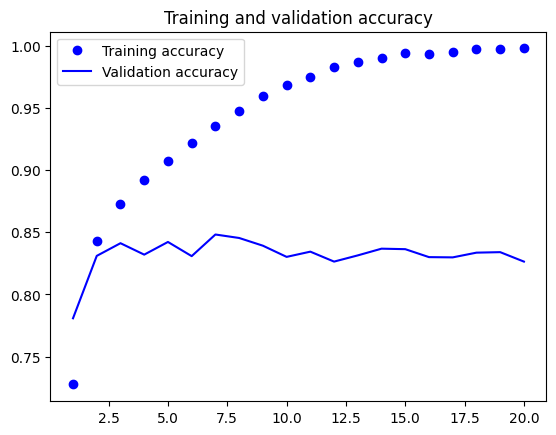

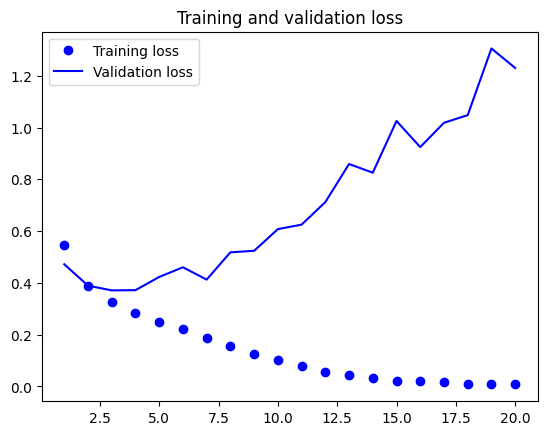

In [ ]:
#Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Understanding padding and masking

# **C. Using an `Embedding` layer with masking enabled**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=128, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history= model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, None, 128)      │      1,280,000 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_9           │ (None, 64)             │         41,216 │ embedding_11[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 64)             │              0 │ bidirectional_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 1)              │             65 │ dropout_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 219ms/step - accuracy: 0.6586 - loss: 0.5924 - val_accuracy: 0.8106 - val_loss: 0.4187
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 222ms/step - accuracy: 0.8529 - loss: 0.3607 - val_accuracy: 0.7972 - val_loss: 0.4679
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 137s 214ms/step - accuracy: 0.8849 - loss: 0.2944 - val_accuracy: 0.8428 - val_loss: 0.4069
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 215ms/step - accuracy: 0.9003 - loss: 0.2553 - val_accuracy: 0.8158 - val_loss: 0.5449
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - accuracy: 0.9136 - loss: 0.2238 - val_accuracy: 0.8344 - val_loss: 0.3921
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 213ms/step - accuracy: 0.9319 - loss: 0.1796 - val_accuracy: 0.8328 - val_loss: 0.4639
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 131s 210ms/step - accuracy: 0.9467 - loss: 0.1516 - val_accuracy: 0.8396 - val_loss: 0.4742
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 216ms/step - accuracy: 0.9592 -

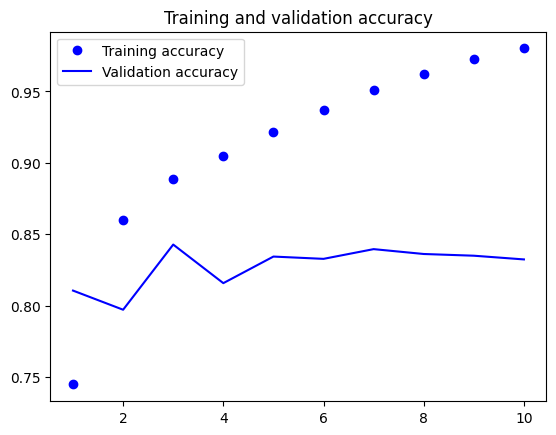

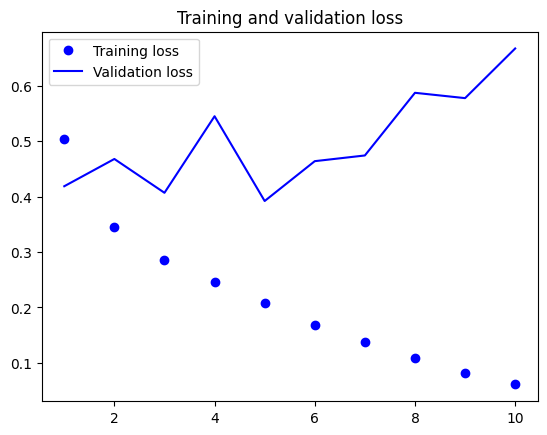

In [ ]:
#Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# D. Using pretrained word embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-22 22:22:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-22 22:22:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-22 22:22:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**Parsing the GloVe word-embeddings file**

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
    mask_zero=True,
)

**Model that uses a pretrained Embedding layer**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, None, 100)      │      1,000,000 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_3 (NotEqual)    │ (None, None)           │              0 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_10          │ (None, 64)             │         34,048 │ embedding_12[0][0],    │
│ (Bidirectional)           │                        │                │ not_equal_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 64)             │              0 │ bidirectional_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 1)              │             65 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 1,034,113 (3.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 179s 275ms/step - accuracy: 0.6191 - loss: 0.6338 - val_accuracy: 0.7982 - val_loss: 0.4462
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 275ms/step - accuracy: 0.8064 - loss: 0.4360 - val_accuracy: 0.8358 - val_loss: 0.3737
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 281ms/step - accuracy: 0.8426 - loss: 0.3637 - val_accuracy: 0.8476 - val_loss: 0.3521
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 266ms/step - accuracy: 0.8679 - loss: 0.3184 - val_accuracy: 0.8552 - val_loss: 0.3416
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 170s 273ms/step - accuracy: 0.8856 - loss: 0.2828 - val_accuracy: 0.8542 - val_loss: 0.3396
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 168s 269ms/step - accuracy: 0.9018 - loss: 0.2508 - val_accuracy: 0.8596 - val_loss: 0.3680
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 263ms/step - accuracy: 0.9123 - loss: 0.2256 - val_accuracy: 0.8526 - val_loss: 0.3623
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 178s 285ms/step - accuracy: 0.9264 -

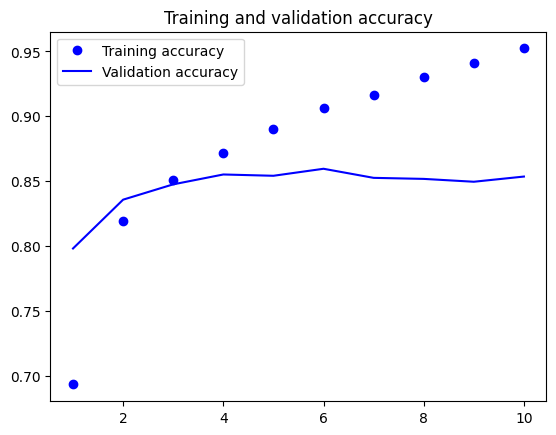

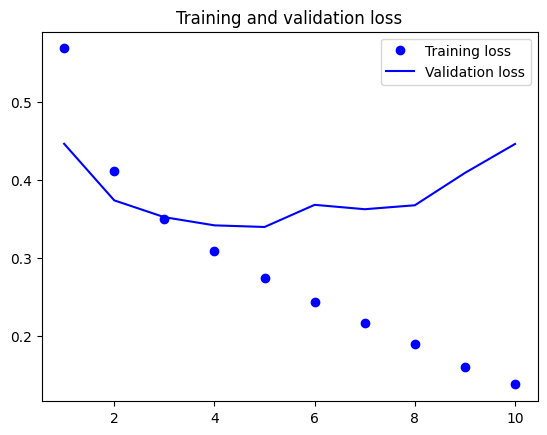

In [ ]:
#Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()